# Houses prices competition

This notebook builds a predictive model for predict the sales price of houses, based on data provided on the [House Prices: Advanced Regression Techniques competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview).

In [287]:
# Load dependencies.
import numpy as np
import pandas as pd

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

import scipy.stats as ss

## 1. Load and clean data

In [288]:
# Load train and test data.
test_data_raw = pd.read_csv('./data/test.csv', sep=',')
train_data_raw = pd.read_csv('./data/train.csv', sep=',')

# Take a quick look into the data.
train_data_raw.head(8)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000


In [289]:
# Columns that can't be used in the prediction.
USELESS_COLUMNS = ['Id']

# Categorical columns that can't be (directly) converted to numeric values.
CATEGORICAL_COLUMNS = [
    'MSSubClass', 'MiscFeature', 'MoSold', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 
    'MasVnrType', 'Heating', 'Electrical', 'GarageType', 'SaleType', 'SaleCondition', 'Neighborhood'
]

# Table for convert categorical columns that represent score-like values to numbers.
SCORES_TO_NUMBERS = {
    "Alley": {"Grvl": 1, "Pave": 2},
    "Street": {"Grvl": 1, "Pave": 2},
    
    "BsmtCond": {"Ex": 6, "Gd": 5, "TA": 4, "Fa": 3, "Po": 2, "No": 1},
    "BsmtQual": {"Ex": 6, "Gd": 5, "TA": 4, "Fa": 3, "Po": 2, "No": 1},
    "ExterCond": {"Ex": 6, "Gd": 5, "TA": 4, "Fa": 3, "Po": 2, "No": 1},
    "ExterQual": {"Ex": 6, "Gd": 5, "TA": 4, "Fa": 3, "Po": 2, "No": 1},
    "FireplaceQu": {"Ex": 6, "Gd": 5, "TA": 4, "Fa": 3, "Po": 2, "No": 1},
    "GarageCond": {"Ex": 6, "Gd": 5, "TA": 4, "Fa": 3, "Po": 2, "No": 1},
    "GarageQual": {"Ex": 6, "Gd": 5, "TA": 4, "Fa": 3, "Po": 2, "No": 1},
    "HeatingQC": {"Ex": 6, "Gd": 5, "TA": 4, "Fa": 3, "Po": 2, "No": 1},
    "KitchenQual": {"Ex": 6, "Gd": 5, "TA": 4, "Fa": 3, "Po": 2, "No": 1},
    "PoolQC": {"Ex": 6, "Gd": 5, "TA": 4, "Fa": 3, "Po": 2, "No": 1},

    "BsmtExposure": {"Gd": 4, "Av": 3, "Mn": 2, "No": 1},

    "BsmtFinType1": {"GLQ": 6, "ALQ": 5, "BLQ": 4, "Rec": 3, "LwQ": 2, "Unf": 1},
    "BsmtFinType2": {"GLQ": 6, "ALQ": 5, "BLQ": 4, "Rec": 3, "LwQ": 2, "Unf": 1},
    
    "Condition1": {"PosA": 7, "PosN": 6, "Norm": 5, "Feedr": 4, "Artery": 3, "RRNn": 2, "RRNe": 2, "RRAn": 1, "RRAe": 1},
    "Condition2": {"PosA": 7, "PosN": 6, "Norm": 5, "Feedr": 4, "Artery": 3, "RRNn": 2, "RRNe": 2, "RRAn": 1, "RRAe": 1},

    "BldgType": {"1Fam": 1, "2FmCon": 2, "2fmCon": 2, "Duplx": 3, "Duplex": 3, "Twnhs": 4.5, "TwnhsI": 4, "TwnhsE": 5},
    "CentralAir": {"N": 0, "Y": 1},
    "Fence": { "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4},
    "Foundation": {"BrkTil": 0, "CBlock": 1, "PConc": 2, "Slab": 3, "Stone": 4, "Wood": 5},
    "Functional": {"Typ": 7, "Min1": 6, "Min2": 5, "Mod": 4, "Maj1": 3, "Maj2": 2, "Sev": 1, "Sal": 0},
    "GarageFinish": {"Fin": 3, "RFn": 2, "Unf": 1},
    "HouseStyle": {"SFoyer": 0, "SLvl": 1, "1Story": 2, "1.5Unf": 3, "1.5Fin": 4, "2Story": 5, "2.5Unf": 6, "2.5Fin": 7},
    "LandContour": {"Lvl": 0, "Bnk": 1, "HLS": 2, "Low": -1},
    "LandSlope": {"Gtl": 1, "Mod": 0, "Sev": -1},
    "LotConfig": {"Inside": 0, "Corner": 1, "CulDSac": 2, "FR2": 3, "FR3": 4},
    "LotShape": {"Reg": 4, "IR1": 3, "IR2": 2, "IR3": 1},
    "MSZoning": {"I": 0, "A": 1, "C": 2, "C (all)": 2, "FV": 3, "RH": 4, "RM": 5, "RL": 6, "RP": 7},
    "PavedDrive": {"N": 0, "P": 1, "Y": 2},
    "Utilities": {"AllPub": 4, "NoSewr": 3, "NoSeWa": 2, "ELO": 1},
} 

def sanitize_data(data):
    # Remove bogus columns.
    data = data.drop(USELESS_COLUMNS, axis=1)

    # Convert some categorical columns (which represent scores) into numeric ones.
    data.replace(SCORES_TO_NUMBERS, inplace=True)

    # Combine columns with two values.
    data['Condition'] = data['Condition1'] + data['Condition2'];
    data = data.drop(['Condition1', 'Condition2'], axis=1)
    data['BsmtFinType'] = data['BsmtFinType1'] + data['BsmtFinType2'];
    data = data.drop(['BsmtFinType1', 'BsmtFinType2'], axis=1)

    # Fill missing data.
    data = data.fillna(0)
    
    return data

train_data = sanitize_data(train_data_raw)
train_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Condition,BsmtFinType
0,60,6,65.0,8450,2,0.0,4,0,4,0,...,0.0,0,0,2,2008,WD,Normal,208500,10,7.0
1,20,6,80.0,9600,2,0.0,4,0,4,3,...,0.0,0,0,5,2007,WD,Normal,181500,9,6.0
2,60,6,68.0,11250,2,0.0,3,0,4,0,...,0.0,0,0,9,2008,WD,Normal,223500,10,7.0
3,70,6,60.0,9550,2,0.0,3,0,4,1,...,0.0,0,0,2,2006,WD,Abnorml,140000,10,6.0
4,60,6,84.0,14260,2,0.0,3,0,4,3,...,0.0,0,0,12,2008,WD,Normal,250000,10,7.0


## 2. Explore data

### 2.1 Numerical columns

In [290]:
# Calculate correlations of numerical columns with 'SalePrice'.
num_corrs = train_data.corr(method ='pearson')['SalePrice']
num_corrs = num_corrs.sort_values()

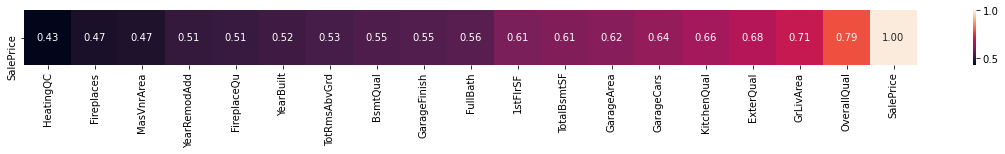

In [291]:
# Draw heatmap for columns with high correlation.
plt.figure(figsize=(20,1))
sns.heatmap(num_corrs[num_corrs >= 0.4].to_frame().T, annot=True, fmt='.2f')
plt.show()

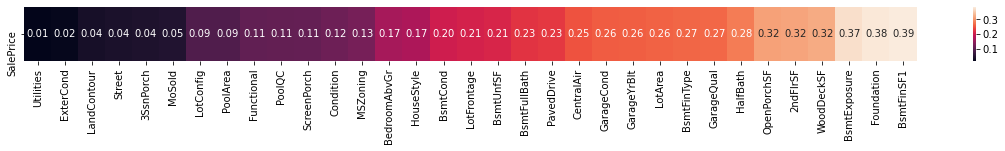

In [292]:
# Draw heatmap for columns with low correlation.
plt.figure(figsize=(20,1))
sns.heatmap(num_corrs[(num_corrs >= 0) & (num_corrs < 0.4)].to_frame().T, annot=True, fmt='.2f')
plt.show()

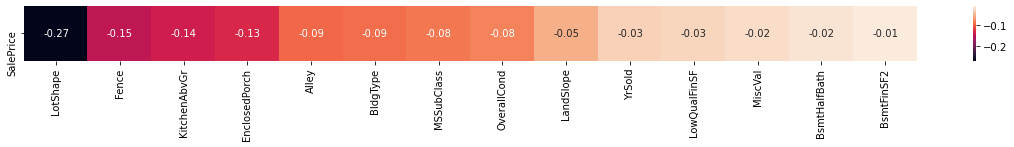

In [293]:
# Draw heatmap for columns with negative correlation.
plt.figure(figsize=(20,1))
sns.heatmap(num_corrs[num_corrs < 0].to_frame().T, annot=True, fmt='.2f')
plt.show()

### 3.2 Categorical columns

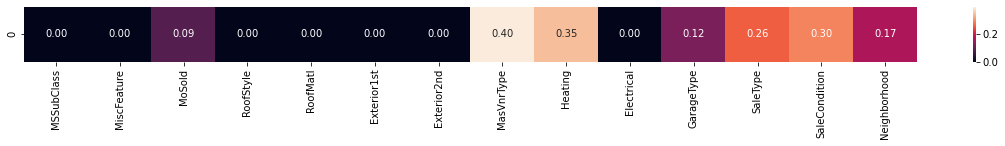

In [294]:
def cramers_v(confusion_matrix):
    """ Calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Calculate correlations of columns with 'SalePrice'.
cat_corrs_index = CATEGORICAL_COLUMNS
cat_corrs = pd.Series([0.0] * len(cat_corrs_index), index=cat_corrs_index)
for column in cat_corrs.index:
    confusion_matrix = pd.crosstab(train_data[column], train_data['SalePrice']).values
    cat_corrs[column] = cramers_v(confusion_matrix)

# Draw heatmap.
plt.figure(figsize=(20,1))
sns.heatmap(cat_corrs.to_frame().T, annot=True, fmt='.2f')
plt.show()

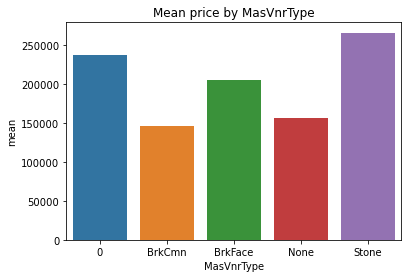

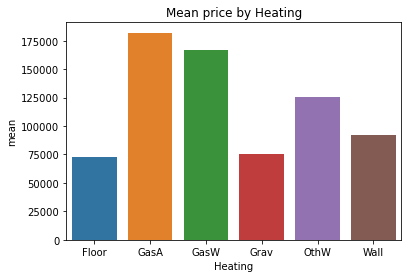

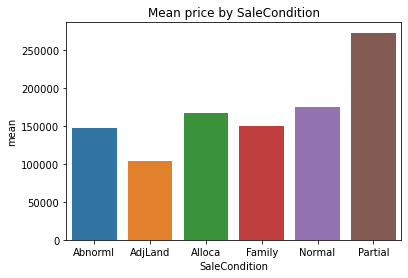

In [295]:
# Draw bar chars for each column whose correlation is superior to 0.3.
for column in CATEGORICAL_COLUMNS:
    if cat_corrs[column] > 0.29:
        # Calculate mean price for each column.
        column_stats = train_data[[column, 'SalePrice']].groupby(column).agg({'SalePrice': ['count', 'sum']})
        column_stats['mean'] = column_stats['SalePrice']['sum'] / column_stats['SalePrice']['count']

        # Draw bar chart.
        plt.figure(figsize=(6,4))
        plt.title("Mean price by " + column)
        sns.barplot(x=column_stats.index, y=column_stats['mean'])

## 3. Build models

In [296]:
def print_pred_errors(y_pred, y_test):
    MSE = np.mean((y_pred - y_test) ** 2)
    RMSE = np.sqrt(MSE)
    price_mean = np.mean(y_test)
    
    print("- Mean squared error: %.0f" % MSE)
    print("- Root mean squared error: %.0f" % RMSE)
    print("- Coefficient of variation: %.4f" % (RMSE / price_mean))
    
def train_and_check_errors(X_train, X_test, y_train, y_test):
    # Create and train classifiers.
    linear_regression = LinearRegression()
    ridge_regression = RidgeCV()
    linear_regression.fit(X_train, y_train)
    ridge_regression.fit(X_train, y_train)

    # Make predictions.
    y_pred_linear = linear_regression.predict(X_test)
    y_pred_ridge = ridge_regression.predict(X_test)

    # Check the accuracy of the predictions.
    print('Linear variance score: %.4f' % linear_regression.score(X_test, y_test))
    print_pred_errors(y_pred_linear, y_test)
    print('\n')
    print('Ridge variance score: %.4f' % ridge_regression.score(X_test, y_test))
    print_pred_errors(y_pred_ridge, y_test)

### 3.1 Regression with numerical columns

In [297]:
# Separate output from input (using all numerical columns).
X = train_data.drop(CATEGORICAL_COLUMNS, axis=1).drop('SalePrice', axis=1)
y = train_data['SalePrice'].copy()

# Separate data into training and testing subsets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=22)
train_and_check_errors(X_train, X_test, y_train, y_test)

Linear variance score: 0.6806
- Mean squared error: 1936073512
- Root mean squared error: 44001
- Coefficient of variation: 0.2446


Ridge variance score: 0.6948
- Mean squared error: 1850224305
- Root mean squared error: 43014
- Coefficient of variation: 0.2391


### 3.2 Regression with highly correlated numerical columns

In [298]:
# Separate output from input (using only numerical columns with higher correlation).
X = train_data.drop(CATEGORICAL_COLUMNS, axis=1)
X = X[num_corrs[num_corrs >= 0.3].index].drop('SalePrice', axis=1)
y = train_data['SalePrice'].copy()

# Separate data into training and testing subsets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=22)
train_and_check_errors(X_train, X_test, y_train, y_test)

Linear variance score: 0.7172
- Mean squared error: 1714582236
- Root mean squared error: 41408
- Coefficient of variation: 0.2302


Ridge variance score: 0.7177
- Mean squared error: 1711502534
- Root mean squared error: 41370
- Coefficient of variation: 0.2300


### 3.3 Regression with numerical and categorical columns

In [299]:
# Separate output from input (using numerical columns and categorical columns with a high correlation).
X = train_data.drop('SalePrice', axis=1)        
y = train_data['SalePrice'].copy()

# Convert categorical columns to numbers.
X = pd.get_dummies(X)

# Separate data into training and testing subsets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=23)
train_and_check_errors(X_train, X_test, y_train, y_test)

Linear variance score: 0.8504
- Mean squared error: 897529761
- Root mean squared error: 29959
- Coefficient of variation: 0.1646


Ridge variance score: 0.8561
- Mean squared error: 863209553
- Root mean squared error: 29380
- Coefficient of variation: 0.1614


### 3.4 Regression with numerical and highly correlated categorical columns

In [300]:
# Separate output from input (using numerical columns and categorical columns with a high correlation).
X = train_data.drop('SalePrice', axis=1)
for column in CATEGORICAL_COLUMNS:
    if cat_corrs[column] > 0.29:
        X = X.drop(column, axis=1)        
y = train_data['SalePrice'].copy()

# Convert categorical columns to numbers.
X = pd.get_dummies(X)

# Separate data into training and testing subsets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=23)
train_and_check_errors(X_train, X_test, y_train, y_test)

Linear variance score: 0.8482
- Mean squared error: 910894206
- Root mean squared error: 30181
- Coefficient of variation: 0.1658


Ridge variance score: 0.8633
- Mean squared error: 820200447
- Root mean squared error: 28639
- Coefficient of variation: 0.1573


## 4. Make predictions

In [301]:
# Initialize train and test data.
X_train = train_data.drop('SalePrice', axis=1)
for column in CATEGORICAL_COLUMNS:
    if cat_corrs[column] > 0.29:
        X_train = X_train.drop(column, axis=1)  
X_train = pd.get_dummies(X_train)
y_train = train_data['SalePrice'].copy()

test_data = sanitize_data(test_data_raw)
for column in CATEGORICAL_COLUMNS:
    if cat_corrs[column] > 0.29:
        test_data = test_data.drop(column, axis=1)  
test_data = pd.get_dummies(test_data)

# Remove extra columns (get_dummies might produce columns not available on the other dataframe)
for column in X_train:
    if column not in test_data:
        X_train = X_train.drop(column, axis=1)  
for column in test_data:
    if column not in X_train:
        test_data = test_data.drop(column, axis=1)  

# Make the predictions.
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)

test_predictions = linear_regression.predict(test_data)

# Generate the submission file (to be uploaded to Kaggle).
output = pd.DataFrame({'Id': test_data_raw.Id, 'SalePrice': test_predictions})
output.to_csv('my_submission.csv', index=False)
print("The submission was successfully saved!")

The submission was successfully saved!
